In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import sys
sys.path.append('../src/')
import argosim

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.imaging_utils import *

# Create antenna array

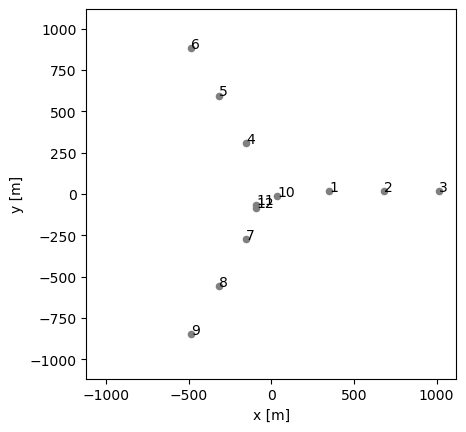

In [2]:
antenna_y = y_antenna_arr(n_antenna=3, r=1e3)
antenna_rand = random_antenna_arr(n_antenna=3, E_lim=250, N_lim=250)
antenna = combine_antenna_arr(antenna_y, antenna_rand)

plot_antenna_arr(antenna)


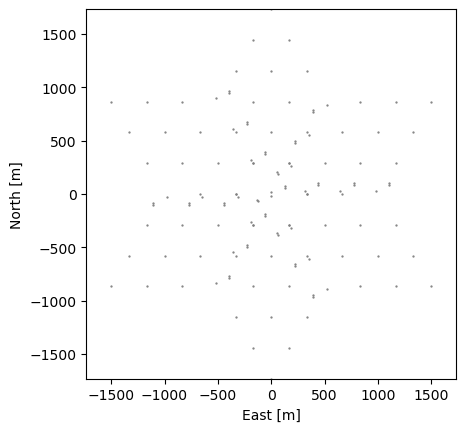

In [3]:
baselines = get_baselines(antenna)
plot_baselines(baselines, ENU=True)

# Source tracking and multiband imaging

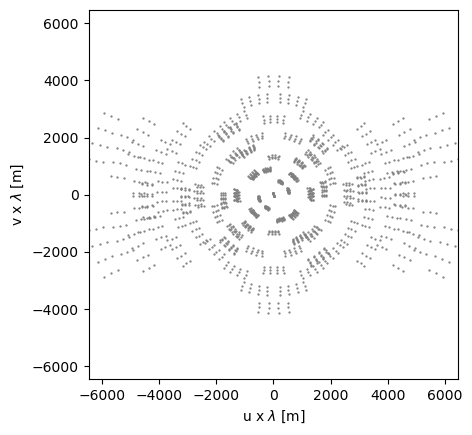

In [4]:
# Multiband parameters
bandwidth = 100e6
n_freqs = 3
f = 1200e6 # 1.2 GHz, lambda = 0.25 m

# Source tracking parameters
source_decl = 90./180*np.pi
array_lat = 35./180*np.pi
track_time = 1
delta_t = 15/60 # 300 segs
t_0 = -0.5
n_times = int(track_time/delta_t)

track = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)

plot_baselines(track)

# Sky model 

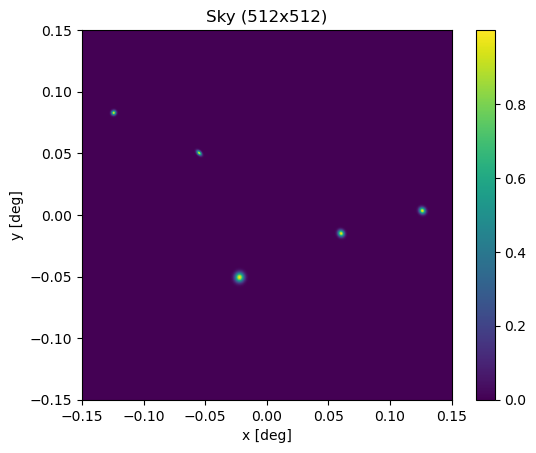

In [5]:
# n_source_sky(shape, pix_size_list, source_intensity_list) 
Npx = 512
fov_size = (.3, .3)
pix_size_list = [10, 7, 7, 5, 5]
source_intensity_list = [1, 1, 1, 1, 1]
sky = n_source_sky((Npx, Npx), pix_size_list, source_intensity_list)
plot_sky(sky, fov_size)


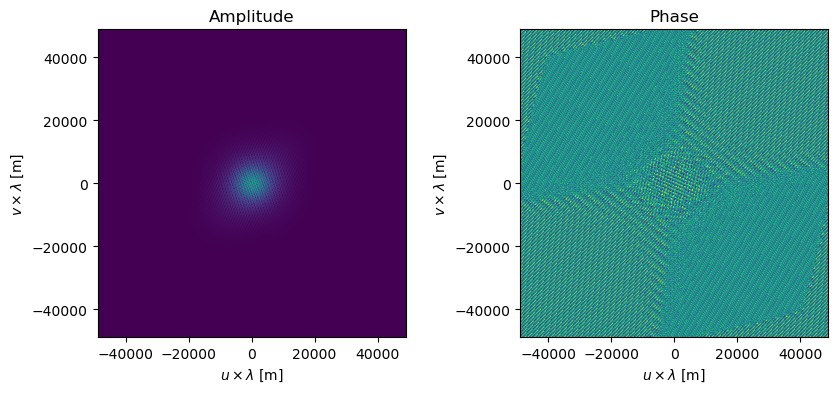

In [6]:
# Fourier transform 
sky_uv = sky2uv(sky)
# sky_uv = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(sky)))
plot_sky_uv(sky_uv, fov_size)

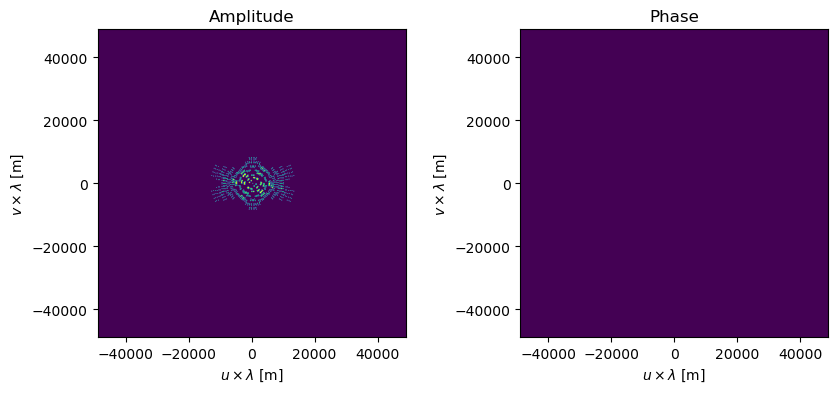

In [7]:
# Fourier transform of the mask
uv_mask, uv_sample_indices  = grid_uv_samples(track, sky_uv.shape, fov_size)
plot_sky_uv(uv_mask, fov_size)

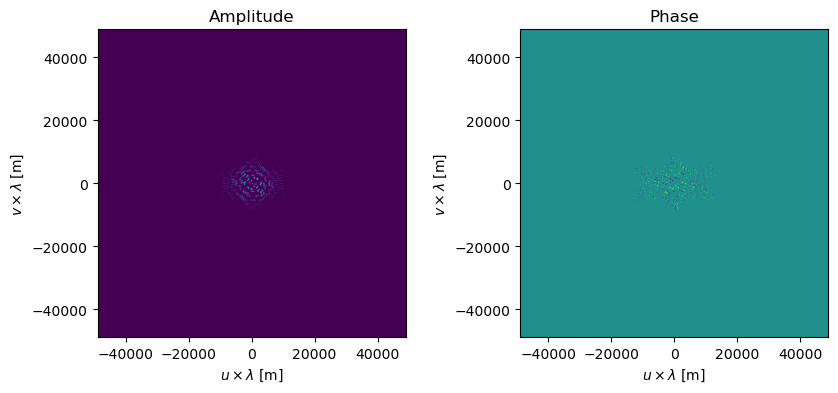

In [8]:
# Visibilities
vis = sky_uv*uv_mask+0+0.j # Add 0+0j to avoid alternating phase between 0 and pi where |vis| = 0. 
plot_sky_uv(vis, fov_size)

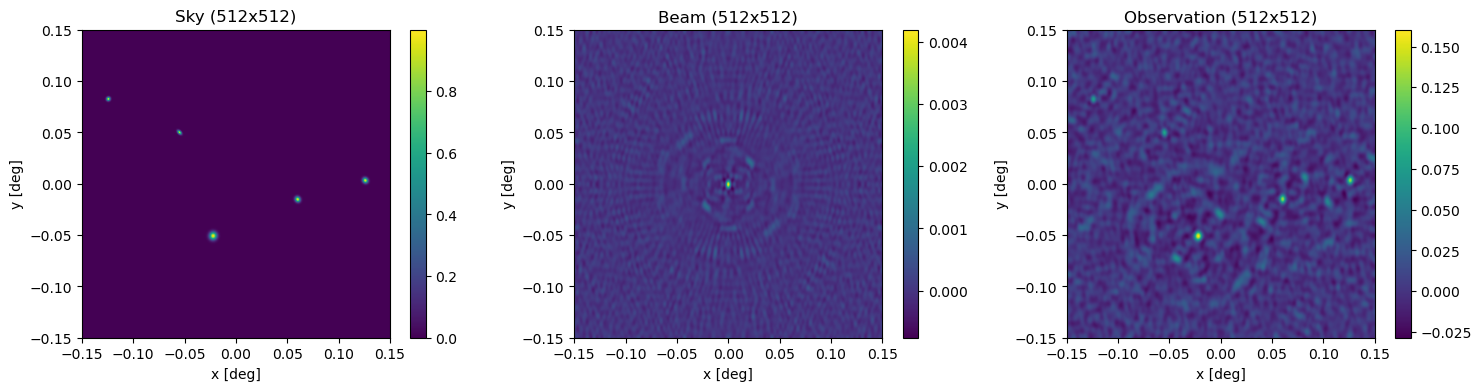

In [9]:
obs = uv2sky(vis)
beam = uv2sky(uv_mask)

fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(sky, fov_size, ax[0], fig, 'Sky')
plot_sky(beam, fov_size, ax[1], fig, 'Beam')
plot_sky(obs, fov_size, ax[2], fig, 'Observation')
